## 数据读入

In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
%matplotlib inline

data = pd.read_csv("voice.csv")

## 数据预处理

In [2]:
# 将数据切分成特征和对应的标签
label_raw = data['label']
features_raw = data.drop('label', axis = 1)

# 将'label'编码成数字值
label_mapping = {'male':1, 'female':0}
label = label_raw.map(label_mapping)

# 对于倾斜的数据使用Log转换
skewed = ['skew', 'kurt']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

In [3]:
# 归一化
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = features_raw.columns
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])
features = features_raw

In [4]:
# train_test_split数据混洗和切分
from sklearn.model_selection import train_test_split

# 将'features'和'label'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, label, 
                                test_size=0.2, random_state=0, stratify=label)

print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 2534 samples.
Testing set has 634 samples.


## 模型

### 导入各个模型

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
def model_accuracy(clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

### GridSearchCV

In [7]:
from sklearn.grid_search import GridSearchCV

def gs_best_estimator(clf, params):
    grid = GridSearchCV(clf, params, cv=10, scoring="accuracy")
    grid.fit(X_train, y_train)
    # print best params
    print('best params: {}'.format(grid.best_params_))
    return grid.best_estimator_

D:\Anaconda\Anaconda3\envs\p1_boston_housing\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda\Anaconda3\envs\p1_boston_housing\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 随机森林

In [8]:
def accuracy_of_rf(rf, n=10):
    scores = []
    i = 0
    while i < n:
        rf.fit(X_train, y_train)
        scores.append(rf.score(X_test, y_test))
        i += 1
    return np.array(scores).mean()

In [9]:
rf = RandomForestClassifier(oob_score=False)
print('Socre of test data: {:.5}'.format(accuracy_of_rf(rf)))

Socre of test data: 0.97476


### 随机森林(坐标下降法调参)

In [10]:
# 作图
import matplotlib.pyplot as plt
def plot(param_name, param_value_array, mu, sigma):
    plt.figure(figsize = (5,5))
    plt.errorbar(param_value_array, mu, yerr=sigma, fmt='cs-')
    plt.title("Searching Best {}".format(param_name), fontsize=14)
    plt.xlabel("value", fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.grid(which="both")
    plt.show()

def kw2param(param_dict):
    pf = []
    for (k, v) in param_dict.items():
        if type(v) == str:
            pf.append('{}=\'{}\''.format(k, v))
        else:
            pf.append('{}={}'.format(k, v))
    return ','.join(pf) 

# 调参函数
def param_search(param_name, param_value_array, **kwargs):
    # 额外指定的参数
    extra_param = ''
    if len(kwargs):
        extra_param = kw2param(kwargs)
    
    # 每个参数取值需要创建的分类器个数
    n_samples = 10

    # 每个n_estimators值对应表现的统计特征：均值和方差
    n_grid = len(param_value_array)
    score_array_mu =np.zeros(n_grid)
    score_array_sigma = np.zeros(n_grid)

    j=0
    for value in param_value_array:
        score_array = np.zeros(n_samples)
        for i in range(0, n_samples):
            exec('clf = RandomForestClassifier({}=value, n_jobs=-1, {})'.format(param_name, extra_param))
            clf.fit(X_train, y_train)
            score_array[i] = clf.score(X_test, y_test)
        score_array_mu[j], score_array_sigma[j] = np.mean(score_array), np.std(score_array)
        j=j+1
    plot(param_name, param_value_array, score_array_mu, score_array_sigma)    
    return score_array_mu, score_array_sigma


# 调参函数，改进，用于衡量分数时用rf的袋外分数，不污染测试集
def param_search_using_oob(param_name, param_value_array, **kwargs):
    # 额外指定的参数
    extra_param = ''
    if len(kwargs):
        extra_param = kw2param(kwargs)
    
    # 每个参数取值需要创建的分类器个数
    n_samples = 10

    # 每个n_estimators值对应表现的统计特征：均值和方差
    n_grid = len(param_value_array)
    score_array_mu =np.zeros(n_grid)
    score_array_sigma = np.zeros(n_grid)

    j=0
    for value in param_value_array:
        score_array = np.zeros(n_samples)
        for i in range(0, n_samples):
            exec('clf = RandomForestClassifier(oob_score=True, {}=value, n_jobs=-1, {})'.format(param_name, extra_param))
            clf.fit(X_train, y_train)
            score_array[i] = clf.oob_score_
        score_array_mu[j], score_array_sigma[j] = np.mean(score_array), np.std(score_array)
        j=j+1
    plot(param_name, param_value_array, score_array_mu, score_array_sigma)    
    return score_array_mu, score_array_sigma

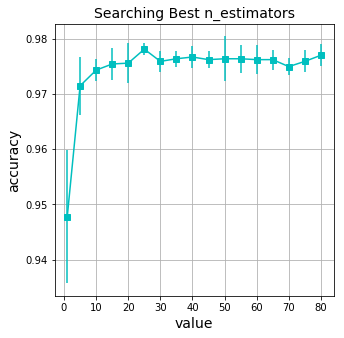

(array([ 0.9477918 ,  0.9714511 ,  0.97429022,  0.97539432,  0.97555205,
         0.97807571,  0.97586751,  0.97634069,  0.97665615,  0.97618297,
         0.97634069,  0.97634069,  0.97618297,  0.97618297,  0.97492114,
         0.97586751,  0.97697161]),
 array([ 0.0120835 ,  0.00525263,  0.00200135,  0.00292543,  0.00368221,
         0.0011041 ,  0.00187292,  0.00141077,  0.00197003,  0.00148801,
         0.00405212,  0.0025433 ,  0.00268139,  0.00179145,  0.00148801,
         0.00200135,  0.00201991]))

In [11]:
# n_estimators调参
param_search(param_name='n_estimators', 
             param_value_array=np.append([1], [i*5 for i in range(1, 17)]))

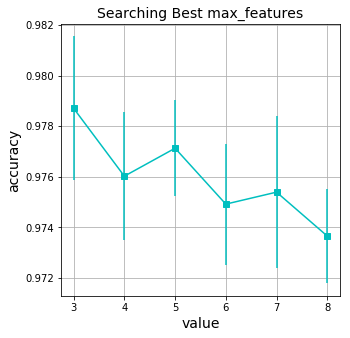

(array([ 0.97870662,  0.97602524,  0.97712934,  0.97492114,  0.97539432,
         0.97365931]),
 array([ 0.00284349,  0.00252366,  0.00189931,  0.00238687,  0.00300927,
         0.00187292]))

In [12]:
# max_features调参
param_search(param_name='max_features', 
             n_estimators=45,
             param_value_array=[x for x in range(3, 9)])

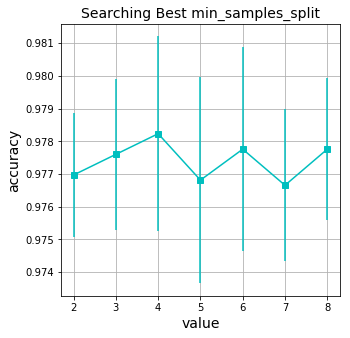

(array([ 0.97697161,  0.97760252,  0.97823344,  0.97681388,  0.97776025,
         0.97665615,  0.97776025]),
 array([ 0.00189274,  0.00231813,  0.00297602,  0.00315851,  0.0031109 ,
         0.00231813,  0.00216841]))

In [13]:
# min_samples_split调参
param_search(param_name='min_samples_split', 
             n_estimators=45,
             max_features=3,
             param_value_array=[x for x in range(2, 9)])

In [14]:
rf_ft= RandomForestClassifier(oob_score=False, n_estimators=45,
             max_features=3, min_samples_split=5, criterion='gini')
print('Socre of test data: {:.5}'.format(accuracy_of_rf(rf_ft, n=10)))

Socre of test data: 0.97685


In [15]:
rf_ft= RandomForestClassifier(oob_score=False, n_estimators=45,
             max_features=3, min_samples_split=5, criterion='entropy')
print('Socre of test data: {:.5}'.format(accuracy_of_rf(rf_ft, n=10)))

Socre of test data: 0.97811


### 调参得分改为oob得分

D:\Anaconda\Anaconda3\envs\p1_boston_housing\lib\site-packages\sklearn\ensemble\forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Anaconda\Anaconda3\envs\p1_boston_housing\lib\site-packages\sklearn\ensemble\forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


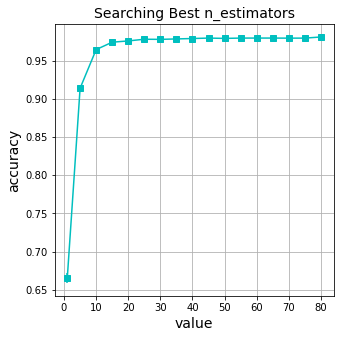

(array([ 0.66479874,  0.91377269,  0.96436464,  0.97403315,  0.97569061,
         0.97790055,  0.9777427 ,  0.97829519,  0.97884767,  0.97940016,
         0.97900552,  0.97940016,  0.97943962,  0.97943962,  0.97932123,
         0.97936069,  0.9808603 ]),
 array([ 0.00656848,  0.00444466,  0.00191753,  0.0019155 ,  0.00221979,
         0.00150789,  0.00146812,  0.00147658,  0.00143594,  0.0011273 ,
         0.00114103,  0.00089643,  0.0012157 ,  0.00137217,  0.0012993 ,
         0.00121057,  0.00081356]))

In [16]:
# n_estimators调参
param_search_using_oob(param_name='n_estimators', 
             param_value_array=np.append([1], [i*5 for i in range(1, 17)]))

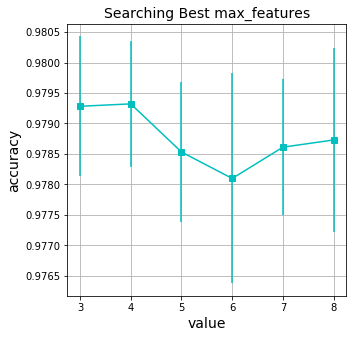

(array([ 0.97928177,  0.97932123,  0.97853197,  0.97809787,  0.97861089,
         0.97872928]),
 array([ 0.00114715,  0.0010321 ,  0.00114648,  0.00172243,  0.0011134 ,
         0.00151253]))

In [17]:
# max_features调参
param_search_using_oob(param_name='max_features', 
             n_estimators=50,
             param_value_array=[x for x in range(3, 9)])

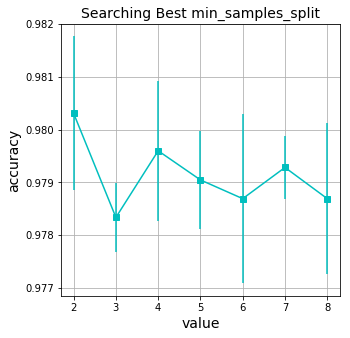

(array([ 0.98030781,  0.97833465,  0.97959747,  0.97904499,  0.97868982,
         0.97928177,  0.97868982]),
 array([ 0.00146014,  0.00064725,  0.00133302,  0.00092465,  0.00160786,
         0.00059195,  0.00143377]))

In [18]:
# min_samples_split调参
param_search_using_oob(param_name='min_samples_split', 
             n_estimators=50,
             max_features=5,
             param_value_array=[x for x in range(2, 9)])

In [19]:
rf_oob_ft= RandomForestClassifier(oob_score=False, n_estimators=50,
             max_features=5, min_samples_split=4, criterion='gini')
print('Socre of test data: {:.5}'.format(accuracy_of_rf(rf_oob_ft, n=10)))

Socre of test data: 0.97666


In [20]:
rf_oob_ft= RandomForestClassifier(oob_score=False, n_estimators=50,
             max_features=5, min_samples_split=4, criterion='entropy')
print('Socre of test data: {:.5}'.format(accuracy_of_rf(rf_oob_ft, n=10)))

Socre of test data: 0.97618


### NB

In [21]:
nb = GaussianNB()
print(model_accuracy(nb))

0.905362776025


### SVM

In [22]:
svm = SVC(kernel='rbf', probability=True, random_state=0)
print(model_accuracy(svm))

0.970031545741


### SVM(调参)

In [23]:
# svm_ft = SVC(kernel='rbf', probability=True, random_state=0)
# params = {'C': [1.0, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
#               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
# print(model_accuracy(gs_best_estimator(svm_ft, params)))

### GDBT

In [24]:
gdbt = GradientBoostingClassifier(random_state=0)
print(model_accuracy(gdbt))

0.973186119874


### GDBT(调参)

In [25]:
# gdbt_ft = GradientBoostingClassifier(random_state=0)
# params = {'n_estimators': [(100+x*50) for x in range(0,5)], 'max_features': [2, 3, 4, 5],
#              'max_depth': [2, 3, 4]}
# print(model_accuracy(gs_best_estimator(gdbt_ft, params)))

### KNN

In [26]:
knn = KNeighborsClassifier()
print(model_accuracy(knn))

0.981072555205


### KNN(调参)

In [27]:
# knn_ft = KNeighborsClassifier()
# params = {'n_neighbors':[x for x in range(1,21)]}
# print(model_accuracy(gs_best_estimator(knn_ft, params)))

### DT

In [28]:
# dt = DecisionTreeClassifier(random_state=0)
# print(model_accuracy(dt))

### DT(调参)

In [29]:
# dt_ft = DecisionTreeClassifier(random_state=0)
# params = {'min_samples_split':[2, 3, 4, 5], 'max_features':[x for x in range(5, 20)]}
# print(model_accuracy(gs_best_estimator(dt_ft, params)))

## Stacking

In [30]:
from sklearn.model_selection import KFold

def get_oof(clf, n_folds):
    ntrain = X_train.shape[0]
    ntest =  X_test.shape[0]
    classnum = len(np.unique(y_train)) # 分类数B
    kf = KFold(n_splits=n_folds, random_state=0)
    oof_train = np.zeros((ntrain, classnum))
    oof_test = np.zeros((ntest, classnum))


    for i,(train_index, test_index) in enumerate(kf.split(X_train)):
        kf_X_train = X_train.iloc[train_index] # 数据
        kf_y_train = y_train.iloc[train_index] # 标签

        kf_X_test = X_train.iloc[test_index]  # k-fold的验证集

        clf.fit(kf_X_train, kf_y_train)
        oof_train[test_index] = clf.predict_proba(kf_X_test)

        oof_test += clf.predict_proba(X_test)
    oof_test = oof_test/float(n_folds)
    return oof_train, oof_test

In [31]:
# clf
lr = LogisticRegression()
nb = GaussianNB()
svm = SVC(kernel='rbf', probability=True, C=5000.0, gamma=0.005)
gdbt = GradientBoostingClassifier(max_features=5, n_estimators=200, 
                                  max_depth=4, random_state=0)
knn = KNeighborsClassifier(n_neighbors=6)
dt = DecisionTreeClassifier(max_features=11, min_samples_split=4, random_state=0)

# first layer
modelist = [svm, gdbt, knn, dt]

new_feature_list = []
new_testdata_list = []
for model in modelist:
    clf_first = model
    oof_train_ , oof_test_ = get_oof(clf=clf_first, n_folds=10)
    new_feature_list.append(oof_train_)
    new_testdata_list.append(oof_test_)

# newfeature
new_X_train = reduce(lambda x,y: np.concatenate((x, y), axis=1), new_feature_list)    
new_X_test = reduce(lambda x,y: np.concatenate((x, y), axis=1), new_testdata_list)

# second layer, using new features
# clf_second = RandomForestClassifier()
clf_second = lr
clf_second.fit(new_X_train, y_train)
print(clf_second.score(new_X_test, y_test))

0.981072555205
